# K-Means Clustering : Flights Data
#### Author : Indra Yanto Simanihuruk

## 0. Setting The Work Environment

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import plotly.graph_objects as go

In [2]:
from google.colab import drive,files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Data Profiling and Summarizing

The dataset used in this work is related to Airline customer value analysis. The downloaded dataset consists of 62988 observations (where each observation represents each customer) and 23 columns

In [3]:
df=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dataset/flight.csv')
df

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62983,18375,5/20/2011,6/5/2013,Female,4,guangzhou,guangdong,CN,25.0,3/31/2014,...,0.0,1134,6/9/2013,297,4.000000,4,1,0.000000,12318,22
62984,36041,3/8/2010,9/14/2013,Male,4,foshan,guangdong,CN,38.0,3/31/2014,...,0.0,8016,1/3/2014,89,37.000000,60,14,0.000000,106972,43
62985,45690,3/30/2006,12/2/2006,Female,4,guangzhou,guangdong,CN,43.0,3/31/2014,...,0.0,2594,3/3/2014,29,166.000000,166,0,0.000000,0,0
62986,61027,2/6/2013,2/14/2013,Female,4,guangzhou,guangdong,CN,36.0,3/31/2014,...,0.0,3934,2/26/2013,400,12.000000,12,0,0.000000,0,0


### 1.1 Description of each feature

- MEMBER_NO : Membership card number
- FFP_DATE : 	Membership time
- FIRST_FLIGHT_DATE : First flight date
- GENDER : Gender
- FFP_TIER : Membership card level
- WORK_CITY : City of work
- WORK_PROVINCE : Province of work
- WORK_COUNTRY : Country of work
- AGE : Age
- FLIGHT_COUNT : Number of flights in the observation window
- LOAD_TIME : End time of observation window
- BP_SUM : Total Basic Integral
- LAST_TO_END : Time from the last flight to the end of observation window
- AVG_DISCOUNT : Average discount rate
- SUM_YR : Fare income of observation window
- SEG_KM_SUM : Total flight kilometers of observation window
- LAST_FLIGHT_DATE : Last flight date
- AVG_INTERVAL : Average flight time interval
- MAX_INTERVAL : Maximum flight interval
- EXCHANGE_COUNT : Points redemption times
- POINTS_SUM : Total cumulative points
- POINT_NOTFLIGHT : Change times of non opportunity points






### 1.2 Objective 

This work is carried out to answer this problem : 

- By using the LRFM method, analyze the customer segmentation (clustering analysis) based on the dataset.

LRFM method was proposed by Chang and Tsay, which complements the famous RMF analysis by adding the new attribute L (Length) , indicating the length of the relationship between the customer and the company measured in unit time. Based on literature study, it is found that the LRFM method is a better alternative than the RFM when clustering the customer value.

## 2. Data Pre-processing

### 2.1 Checking for the data types and missing values

In [4]:
row_n,col_n=df.shape
df_desc=df.isna().sum(axis=0).reset_index()
df_desc.columns=['Variable','Missing_values']
df_desc['Filling_Values (%)']=(row_n-df_desc['Missing_values'])*100/row_n
df_desc['Dtypes']=df.dtypes.values
df_desc

,Variable,Missing_values,Filling_Values (%),Dtypes
0,MEMBER_NO,0,100.000000,int64
1,FFP_DATE,0,100.000000,object
2,FIRST_FLIGHT_DATE,0,100.000000,object
3,GENDER,3,99.995237,object
4,FFP_TIER,0,100.000000,int64
5,WORK_CITY,2269,96.397727,object
6,WORK_PROVINCE,3248,94.843462,object
7,WORK_COUNTRY,26,99.958722,object
8,AGE,420,99.333206,float64
9,LOAD_TIME,0,100.000000,object


Based on the checking result, it appears that :

- MEMBER_NO needs to be dropped
- DATE features need to be transformed into datetime
- Most missing values present in the features that explain customer's demographic such as GENDER, WORK_CITY, WORK_PROVINCE, WORK_COUNTRY, and AGE. Since all those features are likely redundant in clustering analysis, they will also be dropped.
- There exist rows with missing values on SUM_YR columns. Since the filling values of those columns is still very high, i.e 99%, these rows will be dropped

In [5]:
df.drop(['MEMBER_NO','GENDER','WORK_CITY','WORK_PROVINCE','WORK_COUNTRY','AGE'],axis=1,inplace=True)
df

,FFP_DATE,FIRST_FLIGHT_DATE,FFP_TIER,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,11/2/2006,12/24/2008,6,3/31/2014,210,505308,239560.0,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,2/19/2007,8/3/2007,6,3/31/2014,140,362480,171483.0,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,2/1/2007,8/30/2007,6,3/31/2014,135,351159,163618.0,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,8/22/2008,8/23/2008,5,3/31/2014,23,337314,116350.0,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,4/10/2009,4/15/2009,6,3/31/2014,152,273844,124560.0,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62983,5/20/2011,6/5/2013,4,3/31/2014,2,0,0.0,0.0,1134,6/9/2013,297,4.000000,4,1,0.000000,12318,22
62984,3/8/2010,9/14/2013,4,3/31/2014,4,0,0.0,0.0,8016,1/3/2014,89,37.000000,60,14,0.000000,106972,43
62985,3/30/2006,12/2/2006,4,3/31/2014,2,0,0.0,0.0,2594,3/3/2014,29,166.000000,166,0,0.000000,0,0
62986,2/6/2013,2/14/2013,4,3/31/2014,2,0,0.0,0.0,3934,2/26/2013,400,12.000000,12,0,0.000000,0,0


An error raised when converting the LAST_FLIGHT_DATE saying there exist some false datetime such as  2014/2/29  0:00:00. These data will be corrected by changing it into 2014/3/1 0:00:00

In [6]:
df[df['LAST_FLIGHT_DATE']=='2014/2/29  0:00:00']

,FFP_DATE,FIRST_FLIGHT_DATE,FFP_TIER,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
248,6/17/2007,6/17/2007,6,3/31/2014,53,116307,30884.0,70845.0,85000,2014/2/29 0:00:00,32,13.250000,57,0,1.373478,132653,4
447,8/26/2009,4/29/2010,5,3/31/2014,31,96739,26510.0,46323.0,69453,2014/2/29 0:00:00,32,22.766667,75,6,1.375395,101413,7
473,11/10/2006,1/26/2007,5,3/31/2014,49,84754,28693.0,30580.0,65717,2014/2/29 0:00:00,32,14.250000,65,1,1.425974,93153,8
832,7/13/2005,8/6/2005,5,3/31/2014,80,61418,32900.0,36417.0,114222,2014/2/29 0:00:00,32,8.696203,34,2,0.664970,91476,15
1051,5/24/2006,4/21/2007,5,3/31/2014,27,65918,23892.0,35680.0,49859,2014/2/29 0:00:00,32,19.115385,72,4,1.388584,69047,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61539,1/11/2013,7/10/2013,4,3/31/2014,3,0,0.0,955.0,3513,2014/2/29 0:00:00,32,117.000000,211,0,0.276667,0,0
61871,7/26/2009,7/26/2009,4,3/31/2014,2,854,0.0,966.0,1298,2014/2/29 0:00:00,32,135.000000,135,0,0.690000,1094,1
61909,4/11/2011,4/20/2011,4,3/31/2014,2,838,0.0,853.0,2595,2014/2/29 0:00:00,32,1.000000,1,0,0.340000,3356,19
62721,10/31/2007,3/13/2008,4,3/31/2014,2,276,0.0,688.0,1199,2014/2/29 0:00:00,32,78.000000,78,0,0.489525,276,0


In [7]:
#convert date features
df['LAST_FLIGHT_DATE']=df['LAST_FLIGHT_DATE'].apply(lambda x : '2014/3/1 0:00:00' if x=='2014/2/29  0:00:00' else x)
df['FFP_DATE']=pd.to_datetime(df['FFP_DATE'])
df['FIRST_FLIGHT_DATE']=pd.to_datetime(df['FIRST_FLIGHT_DATE'])
df['LOAD_TIME']=pd.to_datetime(df['LOAD_TIME'])
df['LAST_FLIGHT_DATE']=pd.to_datetime(df['LAST_FLIGHT_DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FFP_DATE           62988 non-null  datetime64[ns]
 1   FIRST_FLIGHT_DATE  62988 non-null  datetime64[ns]
 2   FFP_TIER           62988 non-null  int64         
 3   LOAD_TIME          62988 non-null  datetime64[ns]
 4   FLIGHT_COUNT       62988 non-null  int64         
 5   BP_SUM             62988 non-null  int64         
 6   SUM_YR_1           62437 non-null  float64       
 7   SUM_YR_2           62850 non-null  float64       
 8   SEG_KM_SUM         62988 non-null  int64         
 9   LAST_FLIGHT_DATE   62988 non-null  datetime64[ns]
 10  LAST_TO_END        62988 non-null  int64         
 11  AVG_INTERVAL       62988 non-null  float64       
 12  MAX_INTERVAL       62988 non-null  int64         
 13  EXCHANGE_COUNT     62988 non-null  int64         
 14  avg_di

In [8]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62299 entries, 0 to 62298
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FFP_DATE           62299 non-null  datetime64[ns]
 1   FIRST_FLIGHT_DATE  62299 non-null  datetime64[ns]
 2   FFP_TIER           62299 non-null  int64         
 3   LOAD_TIME          62299 non-null  datetime64[ns]
 4   FLIGHT_COUNT       62299 non-null  int64         
 5   BP_SUM             62299 non-null  int64         
 6   SUM_YR_1           62299 non-null  float64       
 7   SUM_YR_2           62299 non-null  float64       
 8   SEG_KM_SUM         62299 non-null  int64         
 9   LAST_FLIGHT_DATE   62299 non-null  datetime64[ns]
 10  LAST_TO_END        62299 non-null  int64         
 11  AVG_INTERVAL       62299 non-null  float64       
 12  MAX_INTERVAL       62299 non-null  int64         
 13  EXCHANGE_COUNT     62299 non-null  int64         
 14  avg_di

In [9]:
df

,FFP_DATE,FIRST_FLIGHT_DATE,FFP_TIER,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,2006-11-02,2008-12-24,6,2014-03-31,210,505308,239560.0,234188.0,580717,2014-03-31,1,3.483254,18,34,0.961639,619760,50
1,2007-02-19,2007-08-03,6,2014-03-31,140,362480,171483.0,167434.0,293678,2014-03-25,7,5.194245,17,29,1.252314,415768,33
2,2007-02-01,2007-08-30,6,2014-03-31,135,351159,163618.0,164982.0,283712,2014-03-21,11,5.298507,18,20,1.254676,406361,26
3,2008-08-22,2008-08-23,5,2014-03-31,23,337314,116350.0,125500.0,281336,2013-12-26,97,27.863636,73,11,1.090870,372204,12
4,2009-04-10,2009-04-15,6,2014-03-31,152,273844,124560.0,130702.0,309928,2014-03-27,5,4.788079,47,27,0.970658,338813,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62294,2013-01-20,2013-01-20,4,2014-03-31,2,0,0.0,0.0,3848,2013-01-20,437,0.000000,0,0,0.000000,0,0
62295,2011-05-20,2013-06-05,4,2014-03-31,2,0,0.0,0.0,1134,2013-06-09,297,4.000000,4,1,0.000000,12318,22
62296,2010-03-08,2013-09-14,4,2014-03-31,4,0,0.0,0.0,8016,2014-01-03,89,37.000000,60,14,0.000000,106972,43
62297,2006-03-30,2006-12-02,4,2014-03-31,2,0,0.0,0.0,2594,2014-03-03,29,166.000000,166,0,0.000000,0,0


### 2.2 Outlier and Anomalies Handling

In [10]:
def plot_hist_box(col,df=df):
  fig,ax=plt.subplots(1,2,figsize=(12,5))
  sns.histplot(df,x=col,ax=ax[1])
  sns.boxplot(y=df[col],ax=ax[0])
  fig.text(0.12,.91,'The Histogram and Boxplot of '+col,fontweight='bold',ha='left',fontsize=13)

In [11]:
df.describe()

,FFP_TIER,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,62299.000000,62299.000000,62299.000000,62299.000000,62299.000000,62299.000000,62299.000000,62299.000000,62299.000000,62299.000000,62299.000000,62299.000000,62299.000000
mean,4.103228,11.941107,11025.168927,5367.238885,5653.590507,17275.697315,172.787541,68.167358,167.409413,0.322750,0.721861,12659.184545,2.746898
std,0.375609,14.091654,16400.358390,8114.504667,8725.725867,21024.229954,181.275570,77.680010,123.199918,1.140964,0.185031,20589.144781,7.389633
min,4.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,2585.000000,1020.000000,833.000000,4852.000000,29.000000,23.750000,81.000000,0.000000,0.612698,2839.000000,0.000000
50%,4.000000,7.000000,5787.000000,2810.000000,2820.000000,10163.000000,105.000000,45.000000,144.000000,0.000000,0.712000,6425.000000,0.000000
75%,4.000000,15.000000,12952.000000,6589.000000,6899.000000,21449.000000,261.000000,82.500000,229.000000,0.000000,0.809140,14432.500000,1.000000
max,6.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.000000,140.000000


Based on above description, one can see that there exist 0 values within SUM_YR_1 and SUM_YR_2, even though the minimum value of SEG_KM_SUM is 368. Another anomaly is also found in the avg_discount column where very small amount of rows are identified as zero.

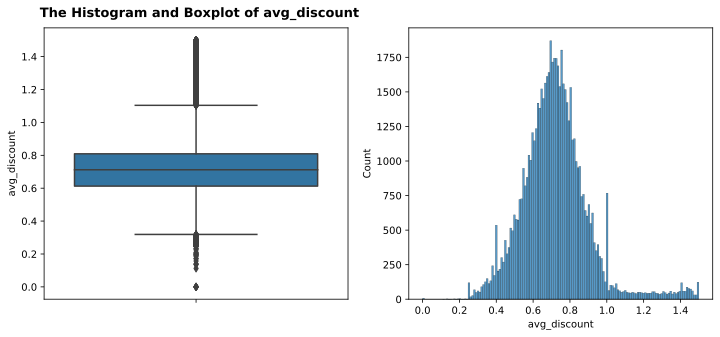

In [12]:
plot_hist_box('avg_discount')

Zero values of SUM_YR_1 and SUM_YR_2 may happen because of the customer's abscence in the flight record. Zero values in Sum_YR and avg_discount may also happen when customer exchanges their points.

To avoid the possibility of incorrect data, all rows with 0 SUM_YR_1 and 0 SUM_YR_2 will be discarded.

In [13]:
discard_1= df['SUM_YR_1']!=0
discard_2= df['SUM_YR_2']!=0
df[~((discard_1) | (discard_2))] #rows that will be discarded

,FFP_DATE,FIRST_FLIGHT_DATE,FFP_TIER,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
4915,2011-09-25,2011-09-25,4,2014-03-31,34,31971,0.0,0.0,47521,2013-06-19,287,12.848485,54,1,0.724819,31971,1
12758,2011-05-02,2011-05-02,4,2014-03-31,25,11519,0.0,0.0,33525,2013-09-30,184,18.083333,55,0,0.543600,12019,1
13379,2011-03-30,2011-04-06,4,2014-03-31,19,15934,0.0,0.0,19731,2013-08-05,240,26.888889,61,3,0.888564,15934,3
17333,2009-10-10,2009-10-10,4,2014-03-31,17,9542,0.0,0.0,23035,2013-10-19,165,31.937500,108,1,0.610588,9542,3
18162,2007-09-23,2007-09-23,4,2014-03-31,13,11929,0.0,0.0,17615,2013-11-24,129,40.083333,162,1,0.765385,11929,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62294,2013-01-20,2013-01-20,4,2014-03-31,2,0,0.0,0.0,3848,2013-01-20,437,0.000000,0,0,0.000000,0,0
62295,2011-05-20,2013-06-05,4,2014-03-31,2,0,0.0,0.0,1134,2013-06-09,297,4.000000,4,1,0.000000,12318,22
62296,2010-03-08,2013-09-14,4,2014-03-31,4,0,0.0,0.0,8016,2014-01-03,89,37.000000,60,14,0.000000,106972,43
62297,2006-03-30,2006-12-02,4,2014-03-31,2,0,0.0,0.0,2594,2014-03-03,29,166.000000,166,0,0.000000,0,0


In [14]:
df=df[((discard_1) | (discard_2))]
df=df.reset_index(drop=True)
df

,FFP_DATE,FIRST_FLIGHT_DATE,FFP_TIER,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,2006-11-02,2008-12-24,6,2014-03-31,210,505308,239560.0,234188.0,580717,2014-03-31,1,3.483254,18,34,0.961639,619760,50
1,2007-02-19,2007-08-03,6,2014-03-31,140,362480,171483.0,167434.0,293678,2014-03-25,7,5.194245,17,29,1.252314,415768,33
2,2007-02-01,2007-08-30,6,2014-03-31,135,351159,163618.0,164982.0,283712,2014-03-21,11,5.298507,18,20,1.254676,406361,26
3,2008-08-22,2008-08-23,5,2014-03-31,23,337314,116350.0,125500.0,281336,2013-12-26,97,27.863636,73,11,1.090870,372204,12
4,2009-04-10,2009-04-15,6,2014-03-31,152,273844,124560.0,130702.0,309928,2014-03-27,5,4.788079,47,27,0.970658,338813,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62039,2005-05-08,2005-08-26,4,2014-03-31,2,400,0.0,960.0,368,2014-01-03,89,70.000000,70,0,0.710000,900,1
62040,2008-11-16,2013-11-30,4,2014-03-31,2,400,0.0,910.0,368,2013-12-02,121,2.000000,2,0,0.670000,400,0
62041,2010-07-08,2011-06-21,4,2014-03-31,2,213,284.0,0.0,1062,2014-02-22,39,420.000000,420,1,0.225000,213,1
62042,2012-12-20,2012-12-20,4,2014-03-31,2,0,330.0,0.0,904,2012-12-24,464,4.000000,4,0,0.250000,0,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62044 entries, 0 to 62043
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FFP_DATE           62044 non-null  datetime64[ns]
 1   FIRST_FLIGHT_DATE  62044 non-null  datetime64[ns]
 2   FFP_TIER           62044 non-null  int64         
 3   LOAD_TIME          62044 non-null  datetime64[ns]
 4   FLIGHT_COUNT       62044 non-null  int64         
 5   BP_SUM             62044 non-null  int64         
 6   SUM_YR_1           62044 non-null  float64       
 7   SUM_YR_2           62044 non-null  float64       
 8   SEG_KM_SUM         62044 non-null  int64         
 9   LAST_FLIGHT_DATE   62044 non-null  datetime64[ns]
 10  LAST_TO_END        62044 non-null  int64         
 11  AVG_INTERVAL       62044 non-null  float64       
 12  MAX_INTERVAL       62044 non-null  int64         
 13  EXCHANGE_COUNT     62044 non-null  int64         
 14  avg_di

### 2.3 Feature Engineering

Some feature engineerings will be performed with a great focus to the concept of LFRM analysis.

- Length (L) : The number of months from the end of the observation window membership time to the end of the observation window. L = LOAD_TIME - FFP_DATE
- Recency (R) : The number of months from the end of the observation window to the last transaction date. R = LOAD_TIME - LAST_FLIGHT_DATE
- Frequency (F) : The number of transactions in the observation time. F = FLIGHT_COUNT
- Monetary (M) : The sum of customer's purchase amount in the observation time. However, this M parameter needs to be altered a little bit since the direct use of it does not reflect the true value of customers, e.g 'long haul low-class cabins' may not have a higher value than 'short haul high-class cabin'. To address this problem better, M parameter will be divided into :
  
  - Total Flight Mileage (M) : Total flight distance during observation time. M = SEG_KM_SUM
  - Average discount rate (C) : Average discount rate during overvation time, is usually related to the customer's cabin or the level of customer value. C = avg_discount

In order to obtain good representation of that LRFMC model, new dataframe (lrfmc_data) that consists of those corresponding columns will be generated.

In [16]:
lrfmc_data=df[['FLIGHT_COUNT','SEG_KM_SUM','avg_discount']].reset_index(drop=True)
lrfmc_data.columns=['F','M','C']
lrfmc_data['R']=(df['LOAD_TIME']-df['LAST_FLIGHT_DATE'])/(np.timedelta64(1,'M'))
lrfmc_data['L']=(df['LOAD_TIME']-df['FFP_DATE'])/(np.timedelta64(1,'M'))
lrfmc_data=lrfmc_data.reindex(columns=['L','R','F','M','C'])
lrfmc_data

,L,R,F,M,C
0,88.905316,0.000000,210,580717,0.961639
1,85.324134,0.197129,140,293678,1.252314
2,85.915522,0.328549,135,283712,1.254676
3,67.253948,3.121214,23,281336,1.090870
4,59.664469,0.131420,152,309928,0.970658
...,...,...,...,...,...
62039,106.745518,2.858375,2,368,0.710000
62040,64.428428,3.909731,2,368,0.670000
62041,44.748352,1.215631,2,1062,0.225000
62042,15.310376,15.178956,2,904,0.250000


In [17]:
lrfmc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62044 entries, 0 to 62043
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   L       62044 non-null  float64
 1   R       62044 non-null  float64
 2   F       62044 non-null  int64  
 3   M       62044 non-null  int64  
 4   C       62044 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 2.4 MB


## 3. Data Processing

In this section, The K-Means model will be applied to the new dataframe lrfmc_data. However, the data must be scaled first by using StandardScaler or standardization method.

In [18]:
std_scaler=StandardScaler()
scaled_data=std_scaler.fit_transform(lrfmc_data)
scaled_lrfmc=pd.DataFrame(scaled_data,columns=['ZL','ZR','ZF','ZM','ZC'])
scaled_lrfmc

,ZL,ZR,ZF,ZM,ZC
0,1.435719,-0.942113,14.034129,26.761370,1.295551
1,1.307162,-0.909017,9.073286,13.126970,2.868199
2,1.328392,-0.886953,8.718940,12.653583,2.880973
3,0.658481,-0.418097,0.781591,12.540723,1.994730
4,0.386035,-0.920049,9.923716,13.898848,1.344346
...,...,...,...,...,...
62039,2.076144,-0.462225,-0.706662,-0.805303,-0.065898
62040,0.557051,-0.285714,-0.706662,-0.805303,-0.282311
62041,-0.149422,-0.738023,-0.706662,-0.772338,-2.689906
62042,-1.206183,1.606259,-0.706662,-0.779843,-2.554648


In [19]:
scaled_lrfmc.describe()

,ZL,ZR,ZF,ZM,ZC
count,6.204400e+04,6.204400e+04,6.204400e+04,6.204400e+04,6.204400e+04
mean,-6.483900e-16,2.137668e-16,-8.880285e-14,-1.160847e-15,-1.994687e-15
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.325304e+00,-9.421129e-01,-7.066621e-01,-8.053033e-01,-3.171335e+00
25%,-8.889187e-01,-7.876661e-01,-6.357929e-01,-5.912676e-01,-5.902378e-01
50%,-2.484934e-01,-3.739695e-01,-3.523162e-01,-3.382817e-01,-5.419990e-02
75%,8.177027e-01,4.810036e-01,2.146373e-01,1.995389e-01,4.713077e-01
max,2.297875e+00,3.079019e+00,1.424674e+01,2.676137e+01,4.208258e+00


### 3.1 KMeans Application

Text(0.12, 0.9, 'The elbow point can be 4,5 and 6')

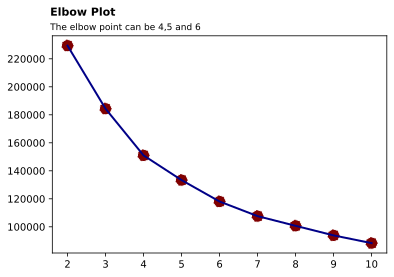

In [20]:
inertia=[]
for i in range(2,11):
  kmeans=KMeans(n_clusters=i,random_state=0)
  kmeans.fit(scaled_lrfmc)
  inertia.append(kmeans.inertia_)
fig,ax=plt.subplots()
sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 2)
sns.scatterplot(x=range(2, 11), y=inertia, s=150, color='#800000',  linestyle='--')
fig.text(0.12,.95,'Elbow Plot',fontweight='bold',ha='left',fontsize=11)
fig.text(0.12,.9,'The elbow point can be 4,5 and 6',ha='left',fontsize=9)

In [21]:
def kmeans_learning(n):
  result = pd.DataFrame({"Cluster category": [f'Customer base-{i}' for i in range(1,n+1)]})
  kmod=KMeans(n_clusters=n,random_state=0)
  kmod.fit(scaled_lrfmc)
  pct = (pd.Series(kmod.labels_).value_counts(normalize=True))*100
  clc = pd.DataFrame(kmod.cluster_centers_)
  r = pd.concat([pct, clc], axis=1)
  result = pd.concat([result, r], axis =1)
  result.columns = ['category', 'Pct', 'ZL','ZR','ZF','ZM','ZC']
  return result
def plot_radar(result,clt,ranges):
  result_lp = result.iloc[:, 2:]
  fig = go.Figure()
  categories = ['Length', 'Recency', 'Frequency', 'Mileage', 'Discount']
  for i in range(clt):
    fig.add_trace(go.Scatterpolar(r = result_lp.loc[i], theta= categories, fill= 'toself', name= f'Customer base {i+1}'))
    
  fig.update_layout(polar= dict(radialaxis= dict(visible= True,range = ranges)),title=f'KMeans Clustering <br>The amount of clusters = {clt}')
  fig.show()

These procedures will be performed to determine the best number of clusters :

#### Number of Clusters = 4

In [22]:
result=kmeans_learning(4)
result

,category,Pct,ZL,ZR,ZF,ZM,ZC
0,Customer base-1,27.841532,1.136931,-0.366537,-0.096799,-0.105825,0.097639
1,Customer base-2,42.355425,-0.696969,-0.407749,-0.170632,-0.170728,-0.137411
2,Customer base-3,8.988782,0.477596,-0.794362,2.433749,2.378306,0.381617
3,Customer base-4,20.814261,-0.308616,1.661929,-0.571984,-0.535828,-0.015482


In [23]:
plot_radar(result,4,[-1,3])

All clusters seems have almost similar charateristics on ZC (avg discount). This will make the result interpretation becomes difficult and not intuitive.

#### Number of Clusters = 5

In [24]:
result=kmeans_learning(5)
result

,category,Pct,ZL,ZR,ZF,ZM,ZC
0,Customer base-1,8.600348,0.483284,-0.797714,2.483261,2.424323,0.310415
1,Customer base-2,6.890271,0.040165,-0.002416,-0.233784,-0.238462,2.163107
2,Customer base-3,19.508736,-0.312948,1.688313,-0.573934,-0.536737,-0.176256
3,Customer base-4,39.654116,-0.700373,-0.415535,-0.160568,-0.160255,-0.258576
4,Customer base-5,25.346528,1.161219,-0.377769,-0.086450,-0.094270,-0.157457


In [25]:
plot_radar(result,5,[-1,3])

On all parameters, each cluster has a distinct characteristic. Probably the best number of clusters.

#### Number of Clusters = 6

In [26]:
result=kmeans_learning(6)
result

,category,Pct,ZL,ZR,ZF,ZM,ZC
0,Customer base-1,23.555864,1.161349,-0.297301,-0.238745,-0.239756,-0.152052
1,Customer base-2,4.358197,0.171515,-0.082739,-0.093393,-0.082706,2.762123
2,Customer base-3,37.682935,-0.719207,-0.363515,-0.275295,-0.272459,-0.236040
3,Customer base-4,2.785120,0.700686,-0.847365,3.901435,3.891760,0.537480
4,Customer base-5,12.689382,0.261152,-0.722149,1.292618,1.229204,0.078877
5,Customer base-6,18.928502,-0.331544,1.722127,-0.574239,-0.537146,-0.111791


In [27]:
plot_radar(result,6,[-1,5])

At first it may looks like that each cluster has a distinct characteristics. However, the radar shape of customer base 4 and 5 are actually quite similar, potentially making the interpretation becomes not so intuitive and difficult.

Less number of clusters makes the result easier and more effective to be interpreted. Hence, the interpretation of each cluster's characteristics will be performed using 5 number of clusters.

### 3.2 Interpretation and Conclusion

Based on LRFMC concept, the airline customer has been successfully clustered into 5 categories, which consist of :

In [28]:
result=kmeans_learning(5)
result

,category,Pct,ZL,ZR,ZF,ZM,ZC
0,Customer base-1,8.600348,0.483284,-0.797714,2.483261,2.424323,0.310415
1,Customer base-2,6.890271,0.040165,-0.002416,-0.233784,-0.238462,2.163107
2,Customer base-3,19.508736,-0.312948,1.688313,-0.573934,-0.536737,-0.176256
3,Customer base-4,39.654116,-0.700373,-0.415535,-0.160568,-0.160255,-0.258576
4,Customer base-5,25.346528,1.161219,-0.377769,-0.086450,-0.094270,-0.157457


In [29]:
plot_radar(result,5,[-1,3])

**Customer base 1 (highest Mileage, Frequency and least Recency)**

These customers have relatively high average discount rate, recent flight history, highest number of flight, highest flight mileage, and long membership time. High discount indicates they usually have high ticket prices. **Considered as the most ideal high-value customers or key customer**. Their proportion is around 8.6% of total customers. Must be prioritized by the company to maintain their satisfaction and loyalty hence becomes able to extend the high consumption level of such customer as much as possible.

- Length : ⭐⭐⭐⭐

- Recency : ⭐⭐⭐⭐⭐

- Frequency : ⭐⭐⭐⭐⭐

- Mileage : ⭐⭐⭐⭐⭐

- Discount : ⭐⭐⭐⭐


**Customer base 2 (highest Discount)**

These customers have the highest discount rate, but there is relatively less recent flight history, low total flight mileage and relatively short membership time (new). The proportion of this customer category is around 7% of total customers. **These customers are considered as potential high value customers or key development customers** as they love the privilege (do not care about discount) whenever they fly, even for such short distance. 
Their satisfactory is very important to be enhanced by the airline so they gradually become loyal key customers.

- Length : ⭐⭐⭐

- Recency : ⭐⭐

- Frequency : ⭐⭐

- Mileage : ⭐⭐

- Discount : ⭐⭐⭐⭐⭐

**Customer base 3 (highest Recency, least Frequency and Mileage)**

These are customers with no recent flight record (highest Recency), least number of flights and mileage,  relativelylow average of discount and membership time. Such customers have low ticket prices, no recent flight history, uncertain loyalty, and care about discount so much (decide to buy ticket at sufficient high discount). It is better for the company to strengthen the contact with such customers since they are very likely to leave . The proportion of this customer is around 19%. **Considered as low value customers**.

- Length : ⭐⭐

- Recency : ⭐

- Frequency : ⭐

- Mileage : ⭐

- Discount : ⭐⭐

**Customer base 4 (lowest Length and Discount)**

These customers have lowest discount rate and length, relatively less number of mileage and frequency, but have recent flight records. **With around 40% proportion, they are considered as general customers**. 

- Length : ⭐

- Recency : ⭐⭐⭐⭐

- Frequency : ⭐⭐⭐

- Mileage : ⭐⭐⭐

- Discount : ⭐

**Customer base 5 (highest length)**

These customers have the longest membership time with proportion around 25% of total customers. They also have recent flight history with relatively high number of frequency and flight. **These are the most devoted customers (important customer retention)**, as they have the longest flight history and are therefore crucial to the company's success.

- Length : ⭐⭐⭐⭐⭐

- Recency : ⭐⭐⭐

- Frequency : ⭐⭐⭐⭐

- Mileage : ⭐⭐⭐⭐

- Discount : ⭐⭐⭐